In [1]:
# import what we going to use
import pandas as pd
import quandl
import math
import numpy as np
from sklearn import preprocessing, cross_validation, svm
from sklearn.linear_model import LinearRegression

C:\Users\caozm\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
# read the data from web
df = quandl.get('SSE/NVD')
# see whats going on
print(df.head())

              High     Low    Last  Previous Day Price  Volume
Date                                                          
2014-03-21  13.550  13.460  13.550               13.36     NaN
2014-03-24  13.385  13.340  13.340               13.55     NaN
2014-03-25  13.320  13.320  13.320               13.34     NaN
2014-03-26  13.350  13.350  13.350               13.32     NaN
2014-03-27  13.075  13.075  13.075               13.35     NaN


In [3]:
# define new features
df = df[['High','Low','Last','Previous Day Price','Volume']]
df['HL_PCT'] = (df['High'] - df['Low']) / df['Low'] * 100.0
df['PCT_change'] = (df['Last'] - df['Previous Day Price']) / df['Previous Day Price'] * 100.0

In [4]:
# use new features
df = df[['Last','HL_PCT','PCT_change','Volume']]
# check again
print(df.head())

              Last    HL_PCT  PCT_change  Volume
Date                                            
2014-03-21  13.550  0.668648    1.422156     NaN
2014-03-24  13.340  0.337331   -1.549815     NaN
2014-03-25  13.320  0.000000   -0.149925     NaN
2014-03-26  13.350  0.000000    0.225225     NaN
2014-03-27  13.075  0.000000   -2.059925     NaN


In [5]:
# replace missing data, make them outliers
forecast_col = 'Last'
df.fillna(-99999, inplace=True)

forecast_out = int(math.ceil(0.03*len(df))) #get 3 percent
print(forecast_out)

df['label'] = df[forecast_col].shift(-forecast_out) # shift the column
df.dropna(inplace=True)
# check the last 5 rows
print(df.tail())

33
              Last    HL_PCT  PCT_change  Volume   label
Date                                                    
2018-07-27  214.98  2.714932   -1.597473   355.0  228.33
2018-07-30  209.99  4.008093   -2.321146   309.0  231.46
2018-07-31  211.13  1.700385    0.542883   569.0  236.93
2018-08-01  209.77  0.658366   -0.644153   126.0  236.17
2018-08-02  216.61  3.979455    3.260714   321.0  233.80


In [6]:
# scale x and y, make sure they have same length
X = np.array(df.drop(['label'],1))
X = preprocessing.scale(X)
X_lately = X[-forecast_out:]
X = X[:-forecast_out:]

df.dropna(inplace=True)

y = np.array(df['label'])
y = y[:-forecast_out]
# confirmed !
print(len(X),len(y))

1008 1008


In [7]:
# split the training and test data
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size=0.2)
# run 10 jobs at the same time
clf = LinearRegression(n_jobs=10)
clf.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=10, normalize=False)

In [8]:
# import pickle, when there is new data, skip the training process
import pickle
with open('linearregression.pickle','wb') as f:
    pickle.dump(clf, f)
pickle_in = open('linearregression.pickle','rb')
clf = pickle.load(pickle_in)

In [9]:
# check accuracy of model
accuracy = clf.score(X_test, y_test)
# pretty good
print(accuracy)

0.968901677597


In [10]:
forecast_set = clf.predict(X_lately)
print(forecast_set, accuracy, forecast_out) #next 30 days prediction value

[ 234.09356286  234.96687638  232.66689391  226.77351797  218.01628558
  217.98140155  215.18921409  217.60371307  214.24221883  218.71110413
  214.05260825  212.09044461  216.74876881  218.66063715  219.66551366
  223.59935534  221.24488489  224.53368119  222.75934132  221.27123231
  228.21145208  226.06788066  224.46976119  224.22504875  223.41308777
  222.29815295  222.15398994  227.70935067  225.28269793  221.28317687
  220.16215174  218.29763858  226.74972425] 0.968901677597 33


In [11]:
# ready to visulize them
import datetime
import matplotlib.pyplot as plt
from matplotlib import style
style.use('ggplot')

In [12]:
df['Forecast'] = np.nan
last_date = df.iloc[-1].name
last_unix = last_date.timestamp()
one_day = 86400
next_unix = last_unix + one_day

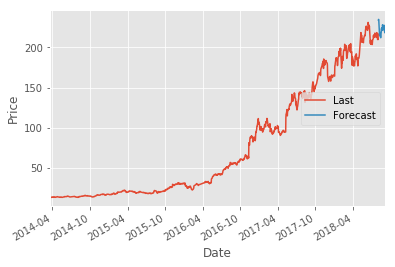

In [13]:
# plot next 30 days trend
for i in forecast_set:
    next_date = datetime.datetime.fromtimestamp(next_unix)
    next_unix += one_day
    df.loc[next_date] = [np.nan for _ in range(len(df.columns)-1)] + [i]
    
df['Last'].plot()
df['Forecast'].plot()
plt.legend(loc=5)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

In [ ]:
# this is only for trend if we use linear regression, can we improve it